In [1]:
import sys
# If you want to re-run, just modify this to where you put the NS_NFMC fork of the PyMC3 repo.
sys.path.insert(1, '/home/richard/pymc3_dev/')
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import theano.tensor as tt

print(f"Running on PyMC3 v{pm.__version__}")

az.style.use("arviz-darkgrid")

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Running on PyMC3 v3.11.0


First example is a 4d Gaussian with 2 modes, with weights defined by w1 and w2. 

In [46]:
n = 4

mu1 = np.ones(n) * (1.0 / 2)
mu2 = -mu1

stdev = 0.1
sigma = np.power(stdev, 2) * np.eye(n)
isigma = np.linalg.inv(sigma)
dsigma = np.linalg.det(sigma)

w1 = 0.3  # one mode with 0.3 of the mass                                                                                                                                                                   
w2 = 1 - w1  # the other mode with 0.7 of the mass                                                                                                                                                          

def two_gaussians(x):
    log_like1 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu1).T.dot(isigma).dot(x - mu1)
    )
    log_like2 = (
        -0.5 * n * tt.log(2 * np.pi)
        - 0.5 * tt.log(dsigma)
        - 0.5 * (x - mu2).T.dot(isigma).dot(x - mu2)
    )
    return pm.math.logsumexp([tt.log(w1) + log_like1, tt.log(w2) + log_like2])

with pm.Model() as model:
    X = pm.Uniform(
        "X",
        shape=n,
        lower=-2.0 * np.ones_like(mu1),
        upper=2.0 * np.ones_like(mu1),
        testval=-1.0 * np.ones_like(mu1),
    )
    llk = pm.Potential("llk", two_gaussians(X))
    trace = pm.sample_ns_nfmc(5000, rho=0.5, chains=2, frac_validate=0.5, alpha=(0,0))
    az_trace = az.from_pymc3(trace)


Initializing normalizing flow based nested sampling...
Sampling 2 chains in 0 job
/home/richard/pymc3_dev/pymc3/sampling.py:1924: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  warnings.warn(
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: [0.]
Stage:   2; Evidence ratio: [7.76052162e-37]
Stage:   3; Evidence ratio: [2.08077036e-19]
Stage:   4; Evidence ratio: [2.56859996e-13]
Stage:   5; Evidence ratio: [2.77594471e-09]
Stage:   6; Evidence ratio: [5.59132521e-06]
Stage:   7; Evidence ratio: [0.00066103]
Stage:   8; Evidence ratio: [0.0079187]
Stage:   9; Evidence ratio: [0.04285371]
Stage:  10; Evidence ratio: [0.11585237]
Stage:  11; Evidence ratio: [0.21401247]
Stage:  12; Evidence ratio: [0.36678278]
Stage:  13; Evidence ratio: [0.60940969]
Stage:  14; Evidence ratio: [0.71757942]
Stage:  15; Evidence ratio: [0.81907253]
Stage:  16; Evidence ratio: [0

<Figure size 720x480 with 0 Axes>

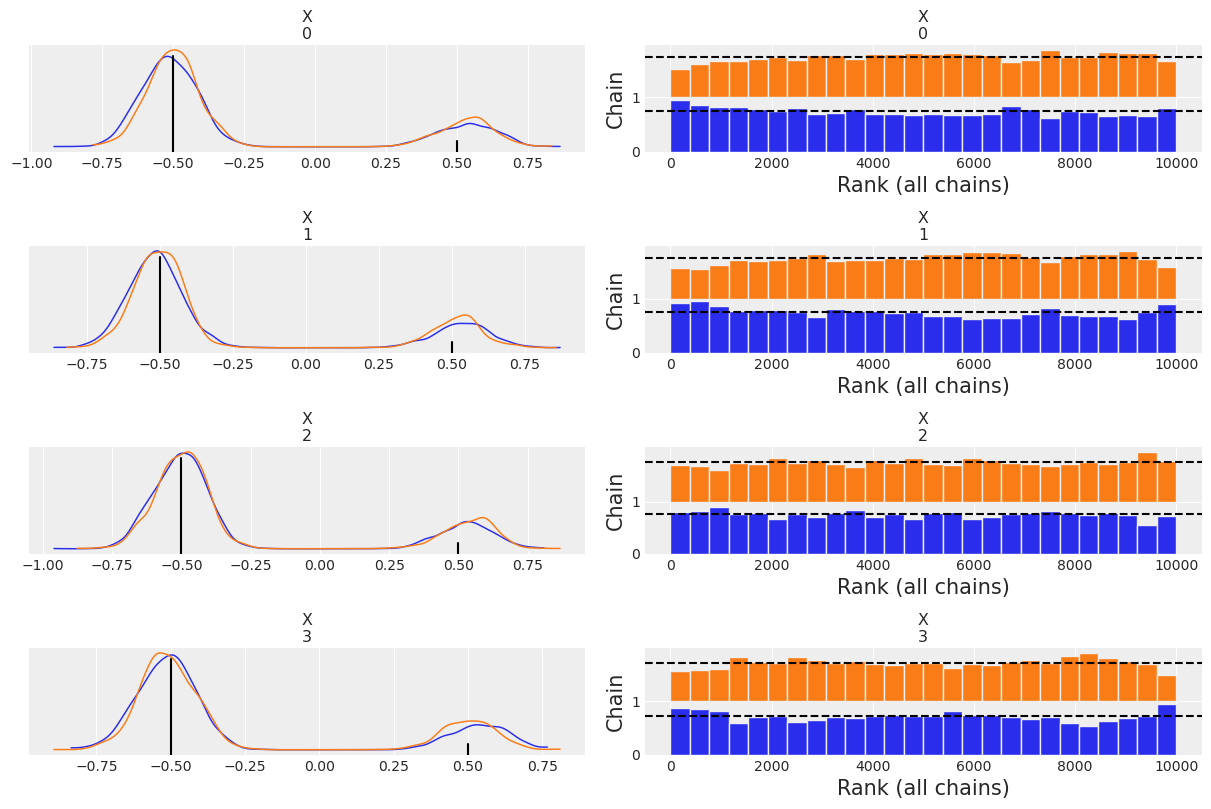

In [47]:
plt.figure()
ax = az.plot_trace(az_trace, compact=False, kind="rank_bars")
for i in range(len(ax)):
    ax[i, 0].axvline(-0.5, 0, 0.9, color="k")
    ax[i, 0].axvline(0.5, 0, 0.1, color="k")
plt.show()

Second example is a basic linear regression problem, simulating a y=ax+b model. Observations are distributed as d~N(ax+b,0.1).

In [33]:
x = np.arange(10)
y = 2 * x + 1 + np.random.normal(scale=0.1, size=len(x))

reg_model = pm.Model()

with reg_model:

    a = pm.Normal('a', mu=2, sigma=1.0)
    b = pm.Normal('b', mu=1, sigma=1.0)
    like = pm.Normal('like', mu=a*x+b, sigma=0.1, observed=y)
    trace = pm.sample_ns_nfmc(20000, rho=0.8, chains=2, frac_validate=0.1, alpha=(0,0))
    az_trace = az.from_pymc3(trace)
    

Initializing normalizing flow based nested sampling...
Sampling 2 chains in 0 job
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: 0.0
Stage:   2; Evidence ratio: [0.]
Stage:   3; Evidence ratio: [6.06800658e-49]
Stage:   4; Evidence ratio: [2.55462358e-09]
Stage:   5; Evidence ratio: [0.01863164]
Stage:   6; Evidence ratio: [0.45776706]
Stage:   7; Evidence ratio: [0.85542032]
Stage:   8; Evidence ratio: [0.96963153]
Stage:   0; Evidence ratio: 0
Stage:   1; Evidence ratio: 0.0
Stage:   2; Evidence ratio: [0.]
Stage:   3; Evidence ratio: [2.16150949e-45]
Stage:   4; Evidence ratio: [9.88152565e-09]
Stage:   5; Evidence ratio: [0.03135086]
Stage:   6; Evidence ratio: [0.48968354]
Stage:   7; Evidence ratio: [0.86901371]
Stage:   8; Evidence ratio: [0.97272942]


<Figure size 720x480 with 0 Axes>

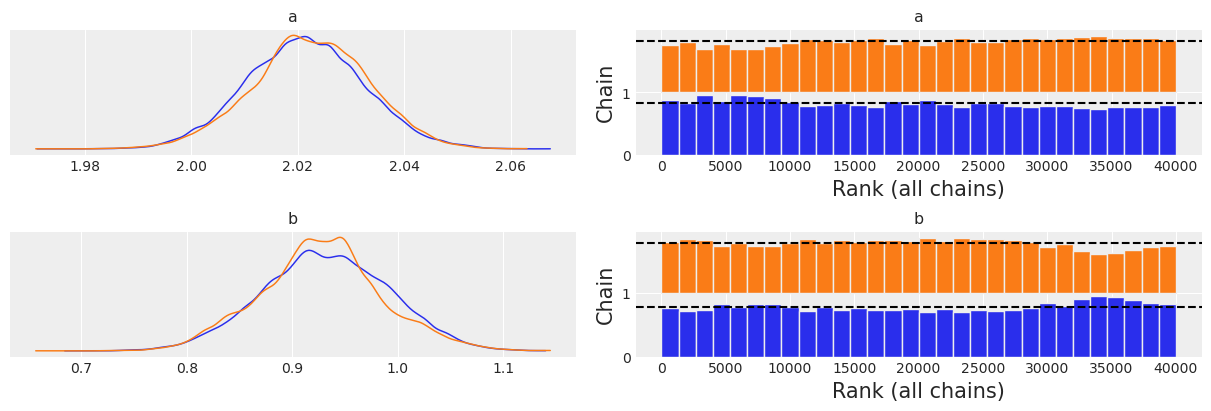

In [34]:
plt.figure()
ax = az.plot_trace(az_trace, compact=False, kind="rank_bars")
plt.show()

As a quick check, we can sample from the same regression model using NUTS.

In [35]:
with reg_model:
    nuts_trace = pm.sample(2000)
    nuts_az = az.from_pymc3(nuts_trace)

/home/richard/pymc3_dev/pymc3/sampling.py:466: FutureWarning: In an upcoming release, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [b, a]


Sampling 2 chains for 1_000 tune and 2_000 draw iterations (2_000 + 4_000 draws total) took 7 seconds.
The number of effective samples is smaller than 25% for some parameters.


<Figure size 720x480 with 0 Axes>

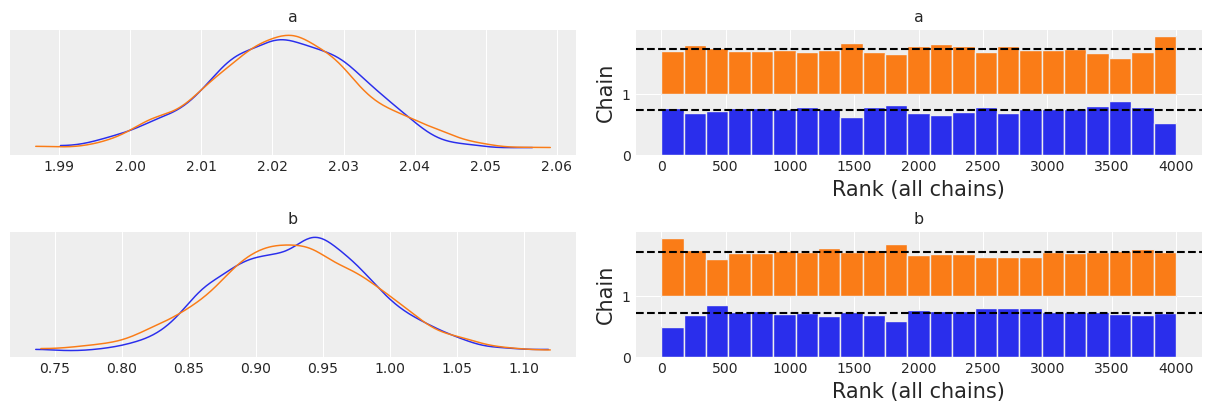

In [36]:
plt.figure()
ax = az.plot_trace(nuts_az, compact=False, kind="rank_bars")
plt.show()